# FitHugh-Nagumo: Nonlinear Dynamical System Analysis

Charles Xu @ Caltech

## System setup

The [FitzHugh-Nagumo model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model) is a two-dimensional simplification of the Hodgkin-Huxley model of spike generation in squid giant axons. It is given by two differential equations:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = \epsilon(v+a-bw)
\end{cases}$$
Where:
- $v$ is the membrane potential
- $w$ is the recovery variable
- $I$ is the stimulus current
- $a$, $b$, and $\epsilon$ are parameters that dictate the system's behavior

To simplify the analysis, I will specify the constant values of the parameters $a$, $b$, and $\epsilon$ empirically determined from squid giant axons. The empirical system is given by:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = 0.08(v+0.7-0.8w)
\end{cases}$$

In [248]:
# Set up the system of differential equations for the FitzHugh-Nagumo model
import sympy as sp

# Define the variables
v, w = sp.symbols('v w')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I = 0

# Define the differential equations
dv_dt = v - (v**3)/3 - w + I
dw_dt = epsilon * (v + a - b*w)

# Print the equations
print("dv/dt =", dv_dt)
print("dw/dt =", dw_dt)


dv/dt = -v**3/3 + v - w
dw/dt = 0.08*v - 0.064*w + 0.056


## Lipschitz continuity of the system

Define a state vector $x\in\mathbb{R}^2$:
$$x \triangleq \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} v \\ w \end{bmatrix}$$
The dynamics can be written in $\dot{x} = f(x)$:
$$\dot{x} = f(x) = \begin{bmatrix} v-\frac{v^3}{3}-w+I \\ 0.08(v+0.7-0.8w) \end{bmatrix}$$

$f(x)$ is continuously differentiable with respect to both $v$ and $w$
Taking the Jacobian gives:
$$Df(x) = \begin{bmatrix} 1-v^2 & -1 \\ 0.08 & -0.064 \end{bmatrix}$$
The partial derivative $\frac{\delta f}{\delta v} = 1-v^2$ grows unboundedly with $v$, so we can conclude that the system $\dot{x}=f(x)$ is not globally Lipschitz continuous. However, because $f(x)$ is continuously differentiable, a local Lipschitz constant $L_0$ can be found by:
$$L_0 = \max_{x\in B_\epsilon(x_0)} \|Df(x)\|$$
indicating that at some point $x_0\in\mathbb{R}^2$, there exists such $L_0$ and some arbitrarily small $\epsilon\in\mathbb{R}_{>0}$ such that $x\in B_\epsilon(x_0)$ implies $\|Df(x)\|\le L_0$.

In [249]:
# Compute the local Lipschitz constant
from scipy.optimize import minimize

# Compute the Jacobian matrix of f(x)
Df = sp.Matrix([[dv_dt.diff(v), dv_dt.diff(w)],
                [dw_dt.diff(v), dw_dt.diff(w)]])
eig_Df = Df.eigenvals()

# Store the eigenvalues as functions of v and w
eig_funcs = [sp.lambdify([v, w], abs(eig)) for eig in eig_Df.keys()] 

# Define the objective function
def objective(x):
    v, w = x
    return -max([eig_func(v, w) for eig_func in eig_funcs])

# Initial guess for v and w
x0 = [0.0, 0.0]

# Solve the optimization problem
res = minimize(objective, x0, method='SLSQP', bounds=[(-2, 2), (-2, 2)])
L0 = -res.fun
print("L0 =", L0)

L0 = 0.9185818460612902


### Local Lipschitz constant

For a bounded region $v:(-2, 2), w:(-2, 2)$ around $x_0 = [0, 0]$, the local Lipschitz constant is $L_0 = 0.92$

## Solutions to the system

In [258]:
# Set the initial conditions
import numpy as np

# Define the time interval
t0 = 0.0
t_final = 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the initial condition
x0 = [-1.0, -1.0]

### Solve using Picard Iteration

In [259]:
# Solve using Picard Iteration
from scipy.integrate import cumtrapz

# Define the system of equations
def f(x):
    v, w = x
    return [v - (v**3)/3 - w + I, epsilon * (v + a - b*w)]

# Initialize the solution
xt = np.tile(x0, (n, 1)).T

# Define tolerance
error = np.inf
tol = 1e0

# Compute the solution
while error > tol:
    xt_next = np.tile(x0, (n, 1)).T + cumtrapz(f(xt), t, initial=0, axis=1)
    error = np.linalg.norm(xt_next - xt, )
    print("delta =", error)
    xt = xt_next
xt_picard = xt

delta = 9.71598164310679
delta = 9.119421914476119
delta = 4.164965132023655
delta = 3.468901046180329
delta = 4.899775000913842
delta = 4.916663070769623
delta = 3.8315065505856896
delta = 1.825155213019637
delta = 1.0950853165641197
delta = 0.4349075069053081


### Solve using ODE solver

In [260]:
# Solve using ODE solver
from scipy.integrate import solve_ivp

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I, epsilon * (v + a - b*w)]

# Compute the solution
sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, method='RK45')
xt_ode45 = sol.y

### Compare the solutions

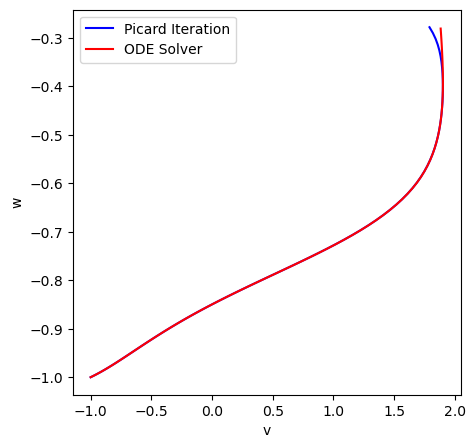

In [261]:
# Compare the solutions of the two methods
import matplotlib.pyplot as plt

# Plot the solutions
plt.figure(figsize=(5, 5))
plt.plot(xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
plt.plot(xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')
plt.xlabel('v')
plt.ylabel('w')
plt.legend()
plt.show()

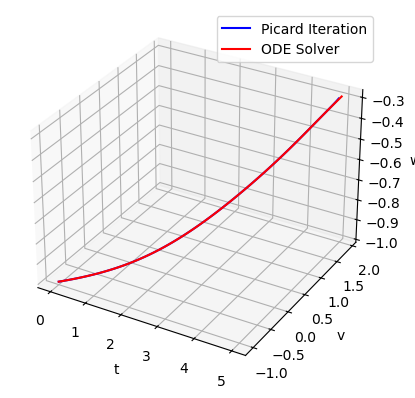

In [262]:
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the solutions
ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

ax.set_xlabel('t')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.legend()

plt.show()

In [263]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_func(angle1=30, angle2=30):
    # Create a new figure
    fig = plt.figure()

    # Create a 3D axis
    ax = fig.add_subplot(111, projection='3d')

    # Plot the solutions
    ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
    ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

    ax.set_xlabel('t')
    ax.set_ylabel('v')
    ax.set_zlabel('w')
    ax.legend()

    # Set the viewing angle
    ax.view_init(angle1, angle2)

    plt.show()

interact(plot_func, angle1=(0,360), angle2=(0,360))

interactive(children=(IntSlider(value=30, description='angle1', max=360), IntSlider(value=30, description='ang…

<function __main__.plot_func(angle1=30, angle2=30)>

## Continuity of solutions
### Condinuous dependence on initial conditions


### Condinuous dependence on parameters